<p style="font-size:34px;text-align:center"> <b>Cancer Prediction</b> </p>

<h1>Problem Statement</h1>

Classify the given genetic variations/mutations based on evidence from text-based Data.

<h2>Real-world objectives</h2>

- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical data (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h1>File descriptions</h1>

<li><b>training_variants</b> - a comma separated file containing the description of the genetic mutations used for training. Fields are <b>ID</b> (the id of the row used to link the mutation to the clinical evidence), <b>Gene</b> (the gene where this genetic mutation is located), <b>Variation</b> (the aminoacid change for this mutations), <b>Class</b> (1-9 the class this genetic mutation has been classified on)</li>

<li><b>training_text</b> - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations.
Fields are <b>ID</b> (the id of the row used to link the clinical evidence to the genetic mutation), <b>Text</b> (the clinical evidence used to classify the genetic mutation)</li>

<h3> Machine Learning Objective </h3>

<p> Objective: Predict the probability of each data-point belonging to each of the nine classes. </p>

<h1>Performance Metric</h1>

* Multi class log-loss

<h1> Importing Libraries</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

<h3> Reading Gene and Variation Data </h3>

In [2]:
df_train_var = pd.read_csv('./training_variants')
print('Number of data points : ', df_train_var.shape[0])
print('Number of features : ', df_train_var.shape[1])
print('Features : ', df_train_var.columns.values)
df_train_var.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
df_train_txt = pd.read_csv("./training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', df_train_txt.shape[0])
print('Number of features : ', df_train_txt.shape[1])
print('Features : ', df_train_txt.columns.values)
df_train_txt.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3> Preprocessing of text </h3>

In [4]:
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        df_train_txt[column][index] = string

In [5]:
#text processing on train data.
for index, row in df_train_txt.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("There is no text description for id: ",index)

There is no text description for id:  1109
There is no text description for id:  1277
There is no text description for id:  1407
There is no text description for id:  1639
There is no text description for id:  2755


In [6]:
train_main_data = pd.merge(df_train_var, df_train_txt, on='ID', how='left')
train_main_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
# checking for null values if any

train_main_data[train_main_data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
# Replacing the NaN values of text with the combination of gene & variation
train_main_data.loc[train_main_data['TEXT'].isnull(), 'TEXT'] = train_main_data['Gene'] + ' ' + train_main_data['Variation']

<h3> Splitting data into train, test and cross validation (64:20:16) </h3>

In [9]:
y_true = train_main_data['Class'].values
train_main_data.Gene = train_main_data.Gene.str.replace('\s+', '_')
train_main_data.Variation = train_main_data.Variation.str.replace('\s+', '_')

X_train, test_df, y_train, y_test = train_test_split(train_main_data, y_true, stratify = y_true, test_size=0.2)

train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify = y_train, test_size=0.2)

In [10]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h3> Distribution of class label across train, validation & test datasets </h3>

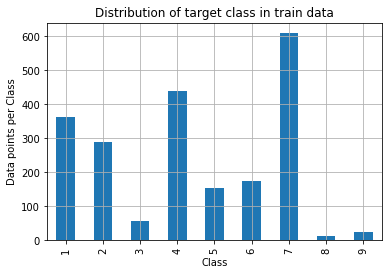

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


In [11]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

train_class_distribution.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of target class in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

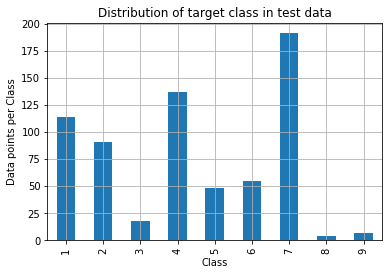

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


In [12]:
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of target class in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

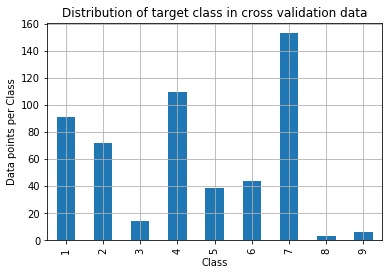

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [13]:
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of target class in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


<h3> Prediction using random model </h3>

In [16]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model", log_loss(y_cv,cv_predicted_y))

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model", log_loss(y_test,test_predicted_y))

predicted_y = np.argmax(test_predicted_y, axis=1)

Log loss on Cross Validation Data using Random Model 2.429878055991688
Log loss on Test Data using Random Model 2.4306818671058656


<h3> Univariate Analysis </h3>

<li>(numerator + 10*alpha) / (denominator + 90*alpha) </li>

In [17]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 dimensional vector
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

<h3>Univariate Analysis on Gene Feature</h3>

<p>For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests.</p>

In [18]:
#response-coding of the Gene feature
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [19]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])

print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 237)


value of alpha =  1e-05  Log loss is: 1.435691704841452
value of alpha =  0.0001  Log loss is: 1.2229208755725223
value of alpha =  0.001  Log loss is: 1.2523741580968315
value of alpha =  0.01  Log loss is: 1.3885299187076967
value of alpha =  0.1  Log loss is: 1.4793283511489586
value of alpha =  1  Log loss is: 1.5079693008042998


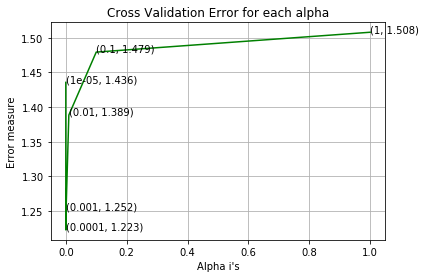

value of best alpha =  0.0001  Train log loss is: 1.017440909614632
value of best alpha =  0.0001  Cross validation log loss is: 1.2229208755725223
value of best alpha =  0.0001  Test log loss is: 1.2136981864918204


In [20]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('value of alpha = ', i, " Log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], " Train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], " Cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], " Test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))


<p style='font-size: 15px'> From the above observation it seems like Gene Feature is stable as cv & test errors would be significantly more than train error</p>

<h3>Univariate Analysis on Variation Feature</h3>

In [21]:
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [22]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1961)


value of alpha =  1e-05  Log loss is: 1.7200419867541883
value of alpha =  0.0001  Log loss is: 1.7048269554412037
value of alpha =  0.001  Log loss is: 1.7033455879542632
value of alpha =  0.01  Log loss is: 1.710974913218888
value of alpha =  0.1  Log loss is: 1.7182398965942984
value of alpha =  1  Log loss is: 1.7189016644549966


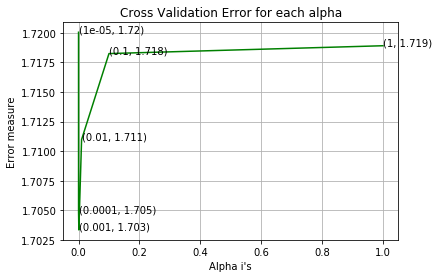

value of best alpha =  0.001 Train log loss is: 1.107709868399205
value of best alpha =  0.001 Cross validation log loss is: 1.7033455879542632
value of best alpha =  0.001 Test log loss is: 1.712374310623357


In [23]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('value of alpha = ', i, " Log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], "Train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], "Cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], "Test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))


<h3>Univariate Analysis on Text Feature</h3>

<li>How many unique words are present in train data?</li>
<li>How are word frequencies distributed?</li>
<li>How to featurize text field?</li>
<li>Is the text feature useful in predicitng target label?</li>

In [24]:
# clean_text is a data frame
# for every row in data frame consider the 'TEXT'

def extract_dictionary_paddle(clean_text):
    dictionary = defaultdict(int)
    for index, row in clean_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [25]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10)/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [26]:
# building a TfidfVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(max_features=1000)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [27]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    clean_text = train_df[train_df['Class'] == i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(clean_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [28]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [29]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [30]:
# normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [31]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

value of alpha =  1e-05 Log loss is: 1.2050395223985402
value of alpha =  0.0001 Log loss is: 1.2169371512333491
value of alpha =  0.001 Log loss is: 1.4629239497252784
value of alpha =  0.01 Log loss is: 1.9165154520494503
value of alpha =  0.1 Log loss is: 2.0461671312241996
value of alpha =  1 Log loss is: 2.033502905478185


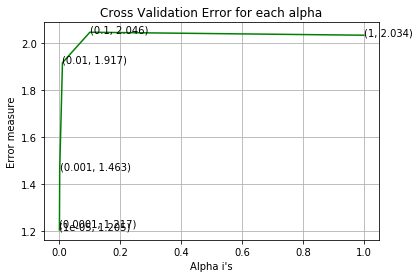

value of best alpha =  1e-05 Train log loss is: 0.7690350438670795
value of best alpha =  1e-05 Cross validation log loss is: 1.2050395223985402
value of best alpha =  1e-05 Test log loss is: 1.147670466243412


In [32]:
# Train a Logistic regression+Calibration model using text features which are one-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('value of alpha = ', i, "Log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], "Train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], "Cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], "Test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))


<h1>Machine Learning Models</h1>

In [33]:
def predict(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])

In [34]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs)

In [35]:
# Merging gene, variance and text features

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [36]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 3198)
(number of data points * number of features) in test data =  (665, 3198)
(number of data points * number of features) in cross validation data = (532, 3198)


In [37]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


<h1>Base Line Model</h1>

<h3>Naive Bayes</h3>

for alpha = 1e-05
Log Loss : 1.2377187922750663
for alpha = 0.0001
Log Loss : 1.2354394272242741
for alpha = 0.001
Log Loss : 1.232808731088096
for alpha = 0.1
Log Loss : 1.231651736327617
for alpha = 1
Log Loss : 1.3033352418491828
for alpha = 10
Log Loss : 1.5246481980933357
for alpha = 100
Log Loss : 1.49372008633776
for alpha = 1000
Log Loss : 1.4820255542500183


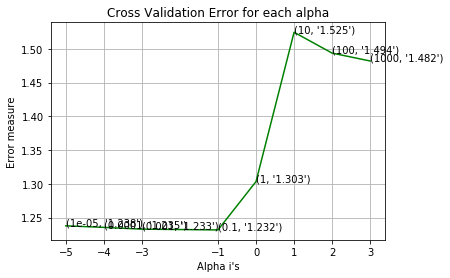

value of best alpha =  0.1 Train log loss is: 0.6055178530765103
value of best alpha =  0.1 Cross validation log loss is: 1.231651736327617
value of best alpha =  0.1 Test log loss is: 1.2507694594003127


In [38]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], "Train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], "Cross validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], "Test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))

<p style="font-size: 15px"> Testing model with best Hyper parameters </p>

In [39]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])

Log Loss : 1.231651736327617
Number of missclassified point : 0.40037593984962405


<p style="font-size: 15px">Feature importance with correctly classified points</p>

In [53]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[0.0683 0.1419 0.0143 0.0867 0.0228 0.0614 0.5975 0.0042 0.0029]]
Actual Class : 2
--------------------------------------------------


<h1>K Nearest Neighbour Classification</h1>

<h3>Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.0704957376042612
for alpha = 11
Log Loss : 1.0512171307600002
for alpha = 15
Log Loss : 1.056276444219369
for alpha = 21
Log Loss : 1.0745908906488733
for alpha = 31
Log Loss : 1.074014152759019
for alpha = 41
Log Loss : 1.092309623729382
for alpha = 51
Log Loss : 1.099111330276348
for alpha = 99
Log Loss : 1.1174169667336606


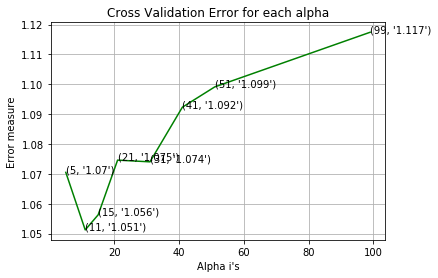

value of best alpha =  11 Train log loss is: 0.6411287747657692
value of best alpha =  11 Cross validation log loss is: 1.0512171307600002
value of best alpha =  11 Test log loss is: 0.9936269263973168


In [40]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('value of best alpha = ', alpha[best_alpha], "Train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('value of best alpha = ', alpha[best_alpha], "Cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('value of best alpha = ', alpha[best_alpha], "Test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))


In [41]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

Log loss : 1.0512171307600002
Number of mis-classified points : 0.37030075187969924


In [42]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 7
The  11  nearest neighbours of the test points belongs to classes [7 7 7 2 2 7 7 7 7 7 7]
Fequency of nearest points : Counter({7: 9, 2: 2})


In [44]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 2
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [2 2 2 2 2 7 2 2 2 2 2]
Fequency of nearest points : Counter({2: 10, 7: 1})


<h1>Logistic Regression with Class Balancing</h1>

for alpha = 1e-06
Log Loss : 1.1845014208326132
for alpha = 1e-05
Log Loss : 1.129257627474964
for alpha = 0.0001
Log Loss : 1.0656763815159958
for alpha = 0.001
Log Loss : 1.0989818523311503
for alpha = 0.01
Log Loss : 1.2844219223045803
for alpha = 0.1
Log Loss : 1.6919008481729776
for alpha = 1
Log Loss : 1.8219633852777009
for alpha = 10
Log Loss : 1.8358799956833465
for alpha = 100
Log Loss : 1.8373991178994429


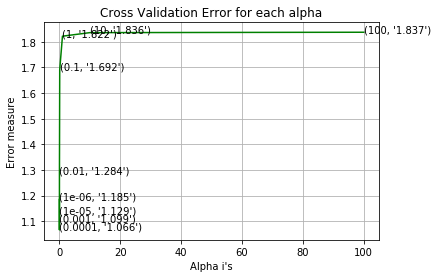

value of best alpha =  0.0001 Train log loss is: 0.434416300963407
value of best alpha =  0.0001 Cross validation log loss is: 1.0656763815159958
value of best alpha =  0.0001 Test log loss is: 1.0047286537912987


In [45]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], "Train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], "Cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('value of best alpha = ', alpha[best_alpha], "Test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

In [46]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

Log loss : 1.0656763815159958
Number of mis-classified points : 0.3533834586466165


<h3>Feature Importance</h3>

In [47]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    increasingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([increasingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([increasingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([increasingorder_ind,train_text_features[i], yes_no])
        increasingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<p>Correctly Classified Points</p>

In [48]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[0.0155 0.1228 0.0022 0.0087 0.0268 0.0214 0.7968 0.0046 0.0012]]
Actual Class : 7
--------------------------------------------------


<h1>Logistic Regression without Class Balancing</h1>

for alpha = 1e-06
Log Loss : 1.2169620910779064
for alpha = 1e-05
Log Loss : 1.2036407034809025
for alpha = 0.0001
Log Loss : 1.074977806443453
for alpha = 0.001
Log Loss : 1.1486388865729547
for alpha = 0.01
Log Loss : 1.384204373146339
for alpha = 0.1
Log Loss : 1.6908431920780396
for alpha = 1
Log Loss : 1.8026580065014648


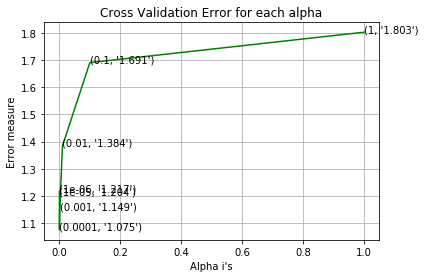

values of best alpha =  0.0001 Train log loss is: 0.42711714774539083
values of best alpha =  0.0001 Cross validation log loss is: 1.074977806443453
values of best alpha =  0.0001 Test log loss is: 1.0165185632015032


In [49]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('values of best alpha = ', alpha[best_alpha], "Train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('values of best alpha = ', alpha[best_alpha], "Cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('values of best alpha = ', alpha[best_alpha], "Test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

In [50]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

Log loss : 1.074977806443453
Number of mis-classified points : 0.35150375939849626


In [51]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[1.620e-02 1.154e-01 2.500e-03 8.600e-03 2.460e-02 2.040e-02 8.088e-01
  3.300e-03 2.000e-04]]
Actual Class : 7
--------------------------------------------------


In [52]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 2
Predicted Class Probabilities: [[4.400e-03 9.351e-01 1.300e-03 3.500e-03 9.400e-03 1.020e-02 3.300e-02
  2.800e-03 3.000e-04]]
Actual Class : 2
--------------------------------------------------


<h1>Support Vector Machine</h1>

for C = 1e-05
Log Loss : 1.1571874359867182
for C = 0.0001
Log Loss : 1.1030028256999778
for C = 0.001
Log Loss : 1.1260065136077304
for C = 0.01
Log Loss : 1.3614951363174506
for C = 0.1
Log Loss : 1.7383113898853553
for C = 1
Log Loss : 1.837704540814888
for C = 10
Log Loss : 1.8377045534521272
for C = 100
Log Loss : 1.8377046114815385


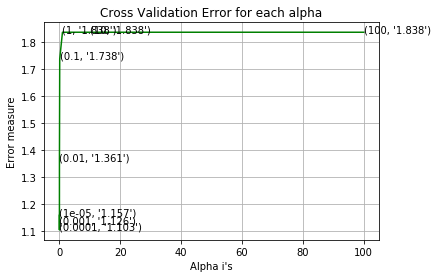

values of best alpha =  0.0001 Train log loss is: 0.4921498267143857
values of best alpha =  0.0001 Cross validation log loss is: 1.1030028256999778
values of best alpha =  0.0001 Test log loss is: 1.06144601929291


In [53]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('values of best alpha = ', alpha[best_alpha], "Train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('values of best alpha = ', alpha[best_alpha], "Cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('values of best alpha = ', alpha[best_alpha], "Test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

In [54]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

Log loss : 1.1030028256999778
Number of mis-classified points : 0.37406015037593987


<h1>Random Forest Classifier</h1>

In [55]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('values of best alpha = ', alpha[int(best_alpha/4)], "Train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('values of best alpha = ', alpha[int(best_alpha/4)], "Cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('values of best alpha = ', alpha[int(best_alpha/4)], "Test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

for n_estimators = 10 and max depth =  2
Log Loss : 2.1551445059758136
for n_estimators = 10 and max depth =  3
Log Loss : 1.8263284864494433
for n_estimators = 10 and max depth =  5
Log Loss : 1.5756795927825002
for n_estimators = 10 and max depth =  10
Log Loss : 2.12287405049164
for n_estimators = 50 and max depth =  2
Log Loss : 1.7518148140141754
for n_estimators = 50 and max depth =  3
Log Loss : 1.5335350985364753
for n_estimators = 50 and max depth =  5
Log Loss : 1.6027990105736878
for n_estimators = 50 and max depth =  10
Log Loss : 1.8857969232543599
for n_estimators = 100 and max depth =  2
Log Loss : 1.6533476542535064
for n_estimators = 100 and max depth =  3
Log Loss : 1.5371889480624876
for n_estimators = 100 and max depth =  5
Log Loss : 1.4930317862873834
for n_estimators = 100 and max depth =  10
Log Loss : 1.7728194944053761
for n_estimators = 200 and max depth =  2
Log Loss : 1.6611017929620673
for n_estimators = 200 and max depth =  3
Log Loss : 1.516518612686551


In [57]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

Log loss : 1.3805416761894722
Number of mis-classified points : 0.5131578947368421


In [64]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0112 0.4086 0.1676 0.0194 0.0295 0.0385 0.2779 0.0355 0.0117]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature


<h1>Conclusion</h1>

* Logistic Regression with class balance gives the best Log Loss of 1.06